In [1]:
# pip install tensorflow==2.0.0-beta1
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
dataset = load_data()

In [5]:
type(dataset)

tuple

In [0]:
(X_train, y_train), (X_test, y_test) = dataset
# X_train.shape       (50000, 32, 32, 3)
# y_train.shape       (50000, 1)
# X_test.shape        (10000, 32, 32, 3)
# y_test.shape        (10000, 1)

In [0]:
y_train = y_train.flatten()
y_test = y_test.flatten()
# y_train.shape       (50000,)
# y_test.shape        (10000,)

In [8]:
K = len(set(y_train))
print(K)

10


In [0]:
batch_size = 32
input_shape = X_train[0].shape
# print(input_shape)            (32, 32, 3)

steps_per_epoch = X_train.shape[0] // batch_size         # 50000 // 32
# print(steps_per_epoch)        1562

steps_per_epoch_test = X_test.shape[0] // batch_size     # 10000 // 32
# print(steps_per_epoch_test)   312

In [0]:
# image_gen_train is an instance of ImageDataGenerator. The arguments tell the generator the ways in which its allowed to modify the data (images)
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

# Generator for our test data
image_gen_test = ImageDataGenerator(          
    rescale = 1./255
)  

In [0]:
# create generators
# we have used flow instead of flow_from_directory used in fruits_360_vgg_keras.ipynb
train_generator = image_gen_train.flow(
    X_train,
    y_train,
    shuffle = True,
    batch_size = batch_size
)

test_generator = image_gen_test.flow(
    X_test,
    y_test,
    shuffle = True,
    batch_size = batch_size
)

In [0]:
# Not needed but just in case
# print(train_generator[0][0].shape)           (32, 32, 32, 3)
# print(test_generator[0][0].shape)            (32, 32, 32, 3)

In [0]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

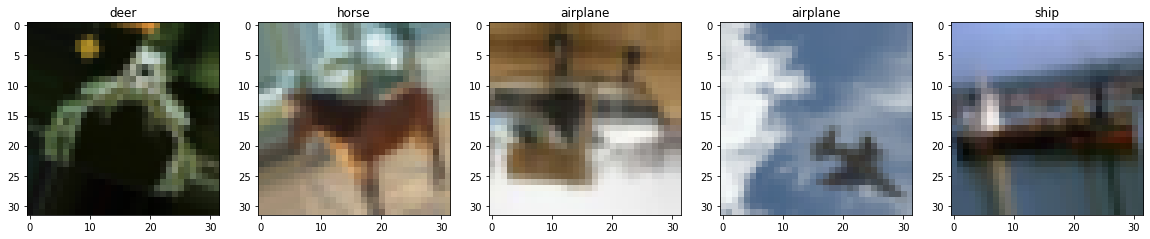

In [14]:
sample_training_images, labels = next(train_generator)
# print(sample_training_images.shape)                 (32, 32, 32, 3)
# print(labels.shape)                                 (32,)

# plotting train images
def plotImages(images_arr, labels):
  # print(images_arr.shape)                           (5, 32, 32, 3)
  fig, axes = plt.subplots(1, 5, figsize=(20,5))
  axes = axes.flatten()
  for img, ax, label in zip(images_arr, axes, labels):
    ax.imshow(img)
    ax.set_title(classes[label])
  plt.show()

plotImages(sample_training_images[:5], labels[:5])       # Plot images 0-4

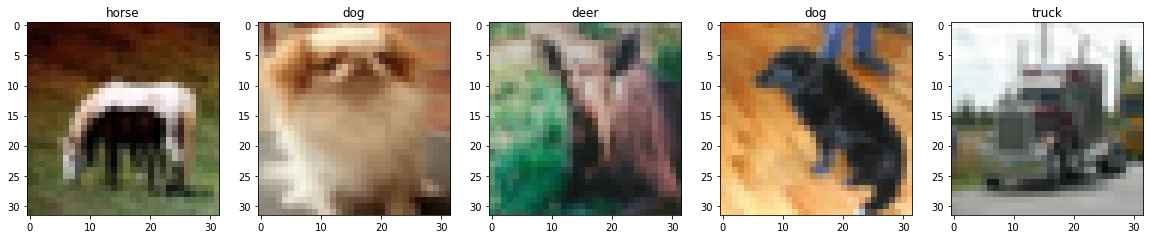

In [15]:
sample_testing_images, labels = next(test_generator)
# print(sample_testing_images.shape)                  (32, 32, 32, 3)
# print(labels.shape)                                 (32,)

# plotting train images
def plotImages(images_arr, labels):
  # print(images_arr.shape)                           (5, 32, 32, 3)
  fig, axes = plt.subplots(1, 5, figsize=(20,5))
  axes = axes.flatten()
  for img, ax, label in zip(images_arr, axes, labels):
    ax.imshow(img)
    ax.set_title(classes[label])
  plt.show()

plotImages(sample_testing_images[:5], labels[:5])       # Plot images 0-4

In [0]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(K, activation='softmax'))

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
model.summary()      # The params 896 come from: filter size (3x3x3x32) + bias term vector of size 32

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        2

In [19]:
# fit the model
EPOCHS = 25
r = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch_test
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1562 steps, validate for 312 steps
Epoch 1/25
1562/1562 [==============================] - 55s 35ms/step - loss: 1.7017 - accuracy: 0.3950 - val_loss: 1.7785 - val_accuracy: 0.4055
Epoch 2/25
1562/1562 [==============================] - 53s 34ms/step - loss: 1.3263 - accuracy: 0.5231 - val_loss: 1.6126 - val_accuracy: 0.4849
Epoch 3/25
1562/1562 [==============================] - 54s 34ms/step - loss: 1.1786 - accuracy: 0.5825 - val_loss: 1.8519 - val_accuracy: 0.4738
Epoch 4/25
1562/1562 [==============================] - 54s 34ms/step - loss: 1.0793 - accuracy: 0.6211 - val_loss: 1.3217 - val_accuracy: 0.5743
Epoch 5/25
1562/1562 [==============================] - 54s 34ms/step - loss: 1.0116 - accuracy: 0.6437 - val_loss: 0.9999 - val_accuracy: 0.6436
Epoch 6/25
1562/1562 [==============================] - 54s 35ms/step - loss: 0.9651 - accuracy: 0.

Text(0.5, 1.0, 'Training & Test Loss')

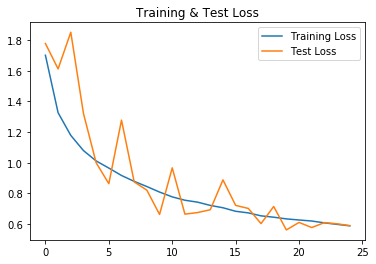

In [20]:
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Training & Test Loss')

Text(0.5, 1.0, 'Training & Test Accuracy')

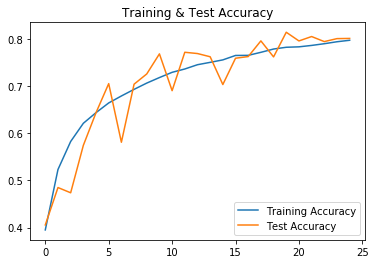

In [21]:
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title('Training & Test Accuracy')